# Prep my data for offline flux calculation

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

## Load merged, preprocessed atmos and ocean data

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Process data for future flux check

In [3]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

#take a sample of the earth for analysis
ds_highRes = ds_in.isel(time = slice(0,365))  
ds_highRes

<xarray.Dataset> Size: 156GB
Dimensions:       (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Heat flux

### Offline Calculation

In [30]:
import aerobulk
from aerobulk import noskin

ql, qh, taux, tauy, evap =  noskin(
        ds_highRes.surface_temp,
        ds_highRes.t_ref,
        ds_highRes.q_ref,
        ds_highRes.u_relative,
        ds_highRes.v_relative,
        slp=ds_highRes.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatfluxHR = qh + ql
heatfluxHR

<xarray.DataArray (time: 365, yt_ocean: 2700, xt_ocean: 3600)> Size: 14GB
dask.array<add, shape=(365, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [47]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2) #default: n_workers=4, threads_per_worker=1
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/40011/status,
Dashboard: /user/panalluri/proxy/40011/status,Workers: 4
Total threads: 8,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40127,Workers: 4
Dashboard: /user/panalluri/proxy/40011/status,Total threads: 8
Started: Just now,Total memory: 125.80 GiB
Comm: tcp://127.0.0.1:36287,Total threads: 2
Dashboard: /user/panalluri/proxy/37117/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:45691,


In [41]:
# prepare code for comparison w CM2.6 online flux
# weighted average

HF_spatialAvg = heatfluxHR.weighted(ds_merged.area_t).mean(dim=["xt_ocean", "yt_ocean"]).load()
HF_spatialAvg

<xarray.DataArray (time: 365)> Size: 3kB
array([-128.98685061, -137.17099558, -137.37042635, -134.31716959,
       -137.55305087, -135.76100547, -134.45585492, -131.51726019,
       -128.54746525, -133.98726898, -136.07246198, -131.05854536,
       -128.58012342, -129.86483778, -135.14782308, -138.93509248,
       -137.65490746, -138.09560354, -133.59700567, -127.80316448,
       -125.93766888, -127.15532897, -131.05872244, -131.27406684,
       -132.33123728, -131.33027088, -128.49987542, -128.68152785,
       -131.31237773, -132.77512425, -130.97231224, -129.44951369,
       -131.90535845, -131.30673892, -125.95516316, -124.01544683,
       -122.79171497, -123.60758979, -124.65512398, -126.21301346,
       -126.77963192, -128.94827227, -127.7975442 , -126.11705992,
       -125.6602055 , -128.27677616, -131.78594391, -135.31237938,
       -137.42247696, -136.19930297, -132.94524423, -129.73982877,
       -126.98822194, -126.10628014, -128.62440085, -128.09066414,
       -128.72153175, -131.72867427, -128.81463267, -129.47901642,
       -133.21022717, -134.60831767, -132.65427317, -131.93570186,
       -130.18540227, -128.08209563, -126.31320822, -123.32444382,
       -121.74059148, -126.6491638 , -129.80911467, -126.08528123,
       -123.77385699, -119.34919753, -120.20925156, -127.15771469,
       -130.72243447, -134.1683288 , -133.2443509 , -132.07609708,
...
       -121.09874083, -120.37079641, -119.11434833, -119.37255636,
       -118.2299478 , -118.1185675 , -120.60671705, -125.53323534,
       -127.79871678, -125.90680245, -124.02382189, -125.63615003,
       -127.20435401, -125.21110125, -120.13323917, -119.54915755,
       -124.08375481, -122.97639858, -120.69385112, -119.39676714,
       -119.70839392, -122.80564287, -124.54948527, -125.17115407,
       -122.61497146, -121.16962724, -120.92600235, -121.59871801,
       -124.12231038, -120.65119608, -121.23284283, -120.56474056,
       -121.90019554, -119.06275993, -118.60481186, -117.21732588,
       -115.19599749, -117.05028654, -122.49693615, -125.80514895,
       -125.74864421, -122.29881557, -123.1395695 , -122.3952602 ,
       -119.5132626 , -118.84333098, -118.2697868 , -117.29467376,
       -118.66183435, -128.10576372, -134.62650053, -133.46462198,
       -132.09063156, -130.00431294, -126.1593699 , -124.41582264,
       -120.70330982, -122.89791296, -123.90808495, -120.51503175,
       -122.96634448, -121.45689342, -118.54573384, -119.07191072,
       -124.41846113, -129.50077529, -127.01750429, -123.89421594,
       -123.66792746, -122.05292731, -120.65660783, -122.17412538,
       -121.9370035 , -123.00315878, -125.32655055, -126.81510267,
       -126.84784754])
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00

In [43]:
# save to bucket

HF_spatialAvg.to_zarr('gs://leap-persistent/panalluri/HF_spatialAvg_weightedinbuilt.zarr')  

In [4]:
# reload from bucket 
HF_spatialAvg = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_spatialAvg_weightedinbuilt.zarr", engine="zarr", chunks={}
)  
HF_spatialAvg

<xarray.Dataset> Size: 6kB
Dimensions:                        (time: 365)
Coordinates:
  * time                           (time) object 3kB 0181-01-01 12:00:00 ... ...
Data variables:
    __xarray_dataarray_variable__  (time) float64 3kB dask.array<chunksize=(365,), meta=np.ndarray>

### Online flux comparison

In [21]:
from CM26_fluxes import get_params
from CM26_fluxes import add_total

label_dict = {
    "ql": "Latent Heatflux [$W/m^2$]",
    "qh": "Sensible Heatflux [$W/m^2$]",
    "q_total": "Turbulent Heatflux\n(Sensible + Latent) [$W/m^2$]",
}

params = get_params("v1.0.1", test=False)
models = ["CM26", "CESM"]
open_kwargs = dict(
    engine="zarr",
    chunks={},
)

max_ice_mask = {}
path = params["paths"]["CM26"]["plotting"]["max_ice_mask"]
da = xr.open_dataset(path, **open_kwargs).max_extent_ice_mask
max_ice_mask["CM26"] = da

# full flux output
full_flux = {}
for model in models:
    full_flux[model] = {}
    for computed in ["online", "offline"]:
        full_flux[model][computed] = {}
        for mean in ["time_mean", "global_mean"]:
            path = params["paths"][model]["plotting"]["full_fluxes"][computed][mean]
            ds = xr.open_dataset(path, **open_kwargs)
            full_flux[model][computed][mean] = ds

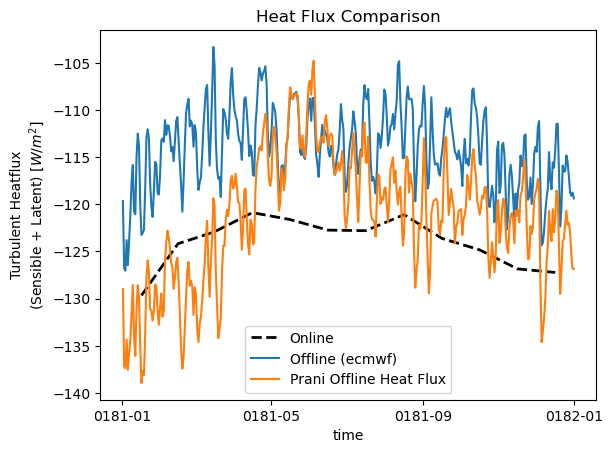

In [42]:
fig, ax = plt.subplots()

ds = full_flux["CM26"]["online"]["global_mean"]
da = add_total(ds)["q_total"]
da.plot(label="Online", ax=ax, lw=2, ls="--", color="k")

ds_offline = full_flux["CM26"]["offline"]["global_mean"]
da_offline = add_total(ds_offline)["q_total"]
da_offline.sel(algo='ecmwf').plot(label=f"Offline ({'ecmwf'})", ax=ax)

HF_spatialAvg.plot(label='Prani Offline Heat Flux', ax=ax)

ax.set_title("Heat Flux Comparison")
ax.set_ylabel(label_dict["q_total"])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")


In [49]:
import gcsfs
import xarray as xr
path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds = xr.open_dataset(path, engine='zarr', chunks={})
ds

<xarray.Dataset> Size: 252GB
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600, nv: 2)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 16B 1.0 2.0
  * time                       (time) object 2kB 0181-01-16 12:00:00 ... 0200...
  * xt_ocean                   (xt_ocean) float64 29kB -279.9 -279.8 ... 79.95
  * xu_ocean                   (xu_ocean) float64 29kB -279.9 -279.8 ... 80.0
  * yt_ocean                   (yt_ocean) float64 22kB -81.11 -81.07 ... 89.98
  * yu_ocean                   (yu_ocean) float64 22kB -81.09 -81.05 ... 90.0
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-06-24 18:36:03,328 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-06-24 18:36:17,490 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


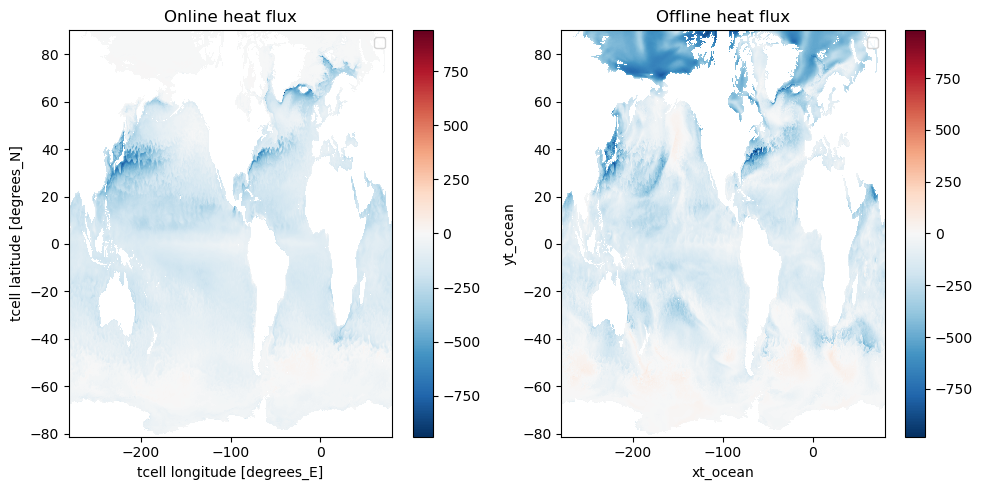

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

online_HF = ds.sens_heat + ds.evap_heat
online_HF.isel(time=0).plot(ax=ax1)
ax1.set_title('Online heat flux')

# Plot data on the second subplot
heatfluxHR.isel(time=0).plot(ax=ax2)
ax2.set_title('Offline heat flux')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Julius flux comparison

In [33]:
#Julius's offline fluxes

ds = xr.open_dataset("gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/fluxes/CM26_fluxes_filter_prod.zarr", engine='zarr')
ds["xt_ocean"] = ds_merged["xt_ocean"]
ds["yt_ocean"] = ds_merged["yt_ocean"]
ds = ds.isel(smoothing=0)
julius_HF = ds.drop(['algo', 'smoothing'])
julius_HF

<xarray.Dataset> Size: 568GB
Dimensions:   (yt_ocean: 2700, xt_ocean: 3600, algo: 1, time: 7305)
Coordinates:
    area_t    (yt_ocean, xt_ocean) float32 39MB ...
    geolat_t  (yt_ocean, xt_ocean) float32 39MB ...
    geolon_t  (yt_ocean, xt_ocean) float32 39MB ...
  * time      (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Dimensions without coordinates: algo
Data variables:
    qh        (algo, time, yt_ocean, xt_ocean) float32 284GB ...
    ql        (algo, time, yt_ocean, xt_ocean) float32 284GB ...
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CM26
    production_spec:   prod
    smoothing_method:  filter

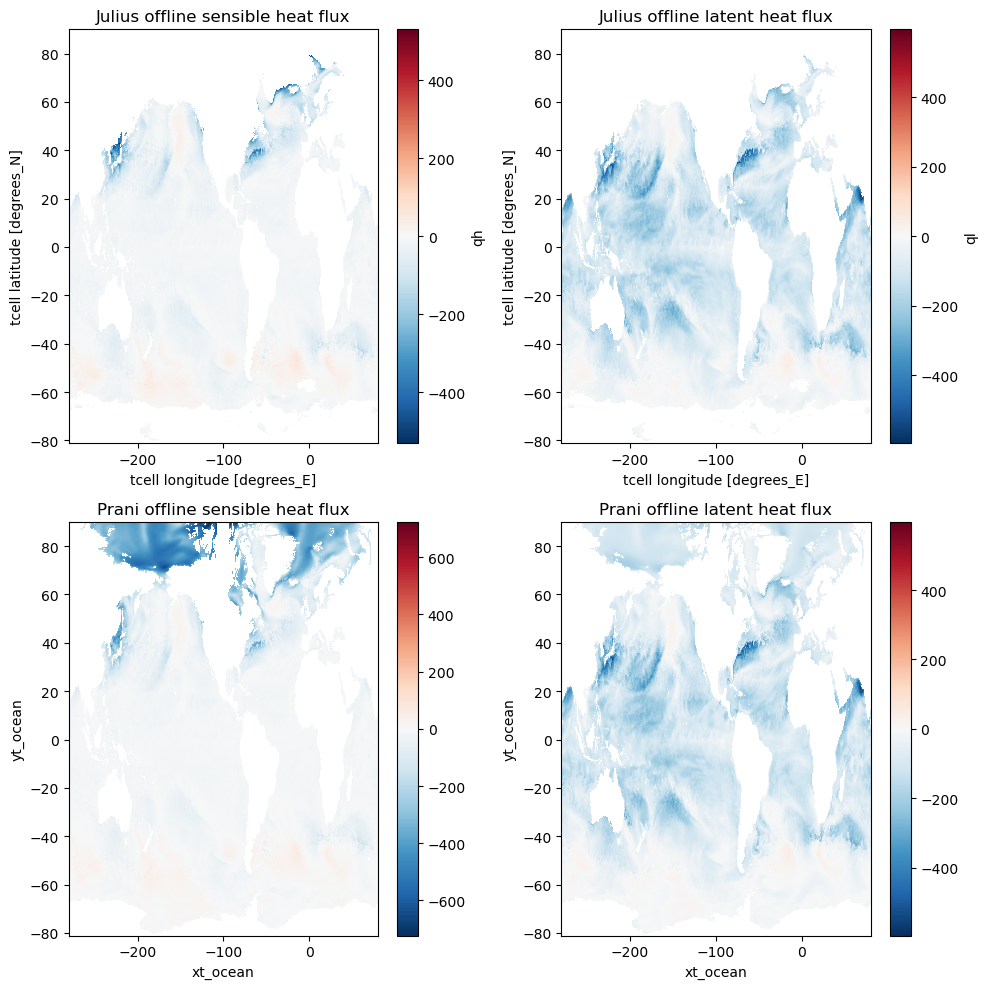

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

julius_HF.qh.isel(time=0).plot(ax=ax1)
ax1.set_title('Julius offline sensible heat flux')

julius_HF.ql.isel(time=0).plot(ax=ax2)
ax2.set_title('Julius offline latent heat flux')

qh.isel(time=0).plot(ax=ax3)
ax3.set_title('Prani offline sensible heat flux')

ql.isel(time=0).plot(ax=ax4)
ax4.set_title('Prani offline latent heat flux')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


#### Could me and Julius have different fluxes because he used an ice mask and I didn't?

# Momentum flux

### Offline calculation

In [25]:
# fix weighted average calculation!!

momfluxHR = np.sqrt( (taux ** 2 + tauy ** 2) )

weighted_vals_MF = momfluxHR * ds_merged.area_t
weighted_sum_MF = np.sum(weighted_vals_MF, axis=(1,2), keepdims=True)
sum_weights = np.sum(ds_merged.area_t)

MF_spatialAvg = ( weighted_sum_MF / sum_weights ).load()
MF_spatialAvg

<xarray.DataArray (time: 365, yt_ocean: 1, xt_ocean: 1)> Size: 3kB
array([[[0.10192423]],

       [[0.11492565]],

       [[0.11431244]],

       [[0.1094233 ]],

       [[0.1135902 ]],

       [[0.1158398 ]],

       [[0.11272162]],

       [[0.10843458]],

       [[0.1050822 ]],

       [[0.10939499]],

...

       [[0.10081616]],

       [[0.10420751]],

       [[0.10271519]],

       [[0.10218345]],

       [[0.10005183]],

       [[0.09781158]],

       [[0.10115827]],

       [[0.10736452]],

       [[0.10705369]],

       [[0.10710571]]])
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean

In [26]:
import gcsfs
import os
import xarray as xr

MF_spatialAvg.to_zarr('gs://leap-persistent/panalluri/MF_spatialAvg_weighted.zarr')  

### Online comparison

In [22]:
import gcsfs
import xarray as xr
path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds = xr.open_dataset(path, engine='zarr', chunks={})
ds

<xarray.Dataset> Size: 252GB
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600,
                                yt_ocean: 2700, xt_ocean: 3600, nv: 2)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                         (nv) float64 16B 1.0 2.0
  * time                       (time) object 2kB 0181-01-16 12:00:00 ... 0200...
  * xt_ocean                   (xt_ocean) float64 29kB -279.9 -279.8 ... 79.95
  * xu_ocean                   (xu_ocean) float64 29kB -279.9 -279.8 ... 80.0
  * yt_ocean                   (yt_ocean) float64 22kB -81.11 -81.07 ... 89.98
  * yu_ocean                   (yu_ocean) float64 22kB -81.09 -81.05 ... 90.0
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 9GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

In [29]:
MomF_CM26 = np.sqrt( ds.tau_x ** 2 + ds.tau_y ** 2 )    
MF_CM26 = MomF_CM26.mean(dim=["xu_ocean", "yu_ocean"]).load()
MF_CM26 = MF_CM26.isel(time=slice(0,12))
MF_CM26

<xarray.DataArray (time: 12)> Size: 48B
array([0.07770471, 0.07816307, 0.07752577, 0.07337903, 0.07299916,
       0.07270807, 0.08129955, 0.07980188, 0.08325319, 0.08703149,
       0.06797787, 0.07077901], dtype=float32)
Coordinates:
  * time     (time) object 96B 0181-01-16 12:00:00 ... 0181-12-16 12:00:00

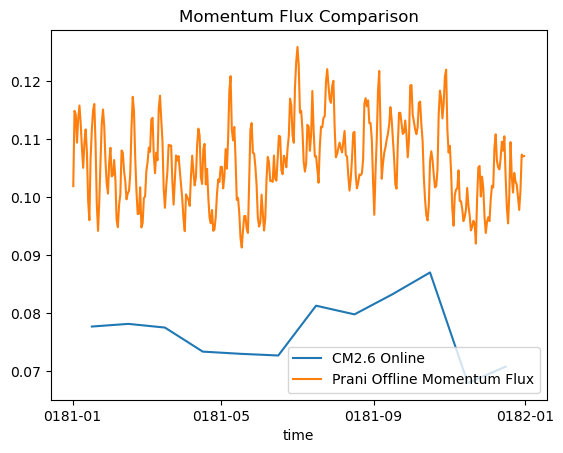

In [30]:
fig, ax = plt.subplots()

MF_CM26.plot(label=f"CM2.6 Online", ax=ax)

MF_spatialAvg.plot(label='Prani Offline Momentum Flux', ax=ax)

ax.set_title("Momentum Flux Comparison")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")


# Freshwater flux

### Offline calculation

In [75]:
# TODO: fix weighted average calculation!

FF_spatialAvg = evap.mean(dim=["xt_ocean", "yt_ocean"]).load()
FF_spatialAvg

<xarray.DataArray (time: 365)> Size: 1kB
array([-3.1599979e-05, -3.2889933e-05, -3.2699925e-05, -3.1940675e-05,
       -3.2449989e-05, -3.2246277e-05, -3.2174699e-05, -3.1806070e-05,
       -3.1214258e-05, -3.2404056e-05, -3.3044682e-05, -3.2430711e-05,
       -3.2033280e-05, -3.2504689e-05, -3.3619501e-05, -3.4251858e-05,
       -3.3592849e-05, -3.3964883e-05, -3.3101387e-05, -3.1743966e-05,
       -3.1172400e-05, -3.1518528e-05, -3.2370055e-05, -3.2496377e-05,
       -3.2669861e-05, -3.2133179e-05, -3.1369444e-05, -3.1501295e-05,
       -3.1826832e-05, -3.2181870e-05, -3.2159722e-05, -3.1898733e-05,
       -3.2946878e-05, -3.3286593e-05, -3.2314474e-05, -3.1276766e-05,
       -3.0648811e-05, -3.1114258e-05, -3.1316238e-05, -3.1771084e-05,
       -3.1770891e-05, -3.1863838e-05, -3.1487532e-05, -3.1308242e-05,
       -3.1406558e-05, -3.1881369e-05, -3.2529384e-05, -3.3505177e-05,
       -3.3804539e-05, -3.3769207e-05, -3.3173885e-05, -3.2409724e-05,
       -3.2151147e-05, -3.2232125e-05, -3.2647222e-05, -3.2330034e-05,
       -3.2511736e-05, -3.3457673e-05, -3.2474978e-05, -3.2627351e-05,
       -3.2917727e-05, -3.3188498e-05, -3.2668333e-05, -3.2097760e-05,
       -3.2027892e-05, -3.2355772e-05, -3.2650125e-05, -3.1928426e-05,
       -3.1794003e-05, -3.2743817e-05, -3.3489658e-05, -3.2620643e-05,
       -3.1986041e-05, -3.0842297e-05, -3.0714818e-05, -3.1665739e-05,
       -3.2689102e-05, -3.3946028e-05, -3.3866017e-05, -3.3200900e-05,
...
       -3.0664207e-05, -3.0232719e-05, -3.0522162e-05, -3.1449392e-05,
       -3.1327752e-05, -3.1211730e-05, -3.1343523e-05, -3.2615491e-05,
       -3.3877175e-05, -3.3406453e-05, -3.2683380e-05, -3.2898806e-05,
       -3.2936234e-05, -3.2429649e-05, -3.1101910e-05, -3.0855794e-05,
       -3.2095551e-05, -3.2046053e-05, -3.2041888e-05, -3.1273692e-05,
       -3.1413936e-05, -3.1906231e-05, -3.1777079e-05, -3.2344949e-05,
       -3.2031821e-05, -3.1623629e-05, -3.1013995e-05, -3.0713996e-05,
       -3.1372434e-05, -3.0184012e-05, -2.9823314e-05, -2.9492774e-05,
       -3.0528510e-05, -3.0218915e-05, -3.0063436e-05, -2.9604193e-05,
       -2.8932589e-05, -2.9299206e-05, -3.0619634e-05, -3.1911357e-05,
       -3.2311022e-05, -3.1279000e-05, -3.0986568e-05, -3.0629566e-05,
       -2.9912866e-05, -2.9727986e-05, -2.9595742e-05, -2.9549203e-05,
       -3.0144964e-05, -3.2408883e-05, -3.3638047e-05, -3.3271226e-05,
       -3.3303335e-05, -3.2724049e-05, -3.1499858e-05, -3.1053085e-05,
       -3.0201005e-05, -3.0338950e-05, -3.0168279e-05, -2.9648783e-05,
       -3.0865209e-05, -3.0514064e-05, -2.9495553e-05, -2.9360155e-05,
       -3.0398847e-05, -3.1682383e-05, -3.1369254e-05, -3.0801781e-05,
       -3.0308709e-05, -2.9567522e-05, -2.9089491e-05, -2.9528674e-05,
       -2.9331884e-05, -2.9482986e-05, -3.0417086e-05, -3.0961826e-05,
       -3.0979973e-05], dtype=float32)
Coordinates:
  * time     (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00

In [76]:
import gcsfs
import os
import xarray as xr

FF_spatialAvg.to_zarr('gs://leap-persistent/panalluri/FF_spatialAvg_pointwiseGlobe.zarr')  

### Online calculation

In [96]:
FF_CM26 = ds.evap.mean(dim=["xt_ocean", "yt_ocean"]).load()
FF_CM26 = FF_CM26.isel(time=slice(0,12))
FF_CM26

<xarray.DataArray 'evap' (time: 12)> Size: 48B
array([-2.7923712e-05, -2.7629882e-05, -2.7708089e-05, -2.7083166e-05,
       -2.6499034e-05, -2.5816928e-05, -2.5603076e-05, -2.5340267e-05,
       -2.6272075e-05, -2.6825368e-05, -2.6769545e-05, -2.6972546e-05],
      dtype=float32)
Coordinates:
  * time     (time) object 96B 0181-01-16 12:00:00 ... 0181-12-16 12:00:00

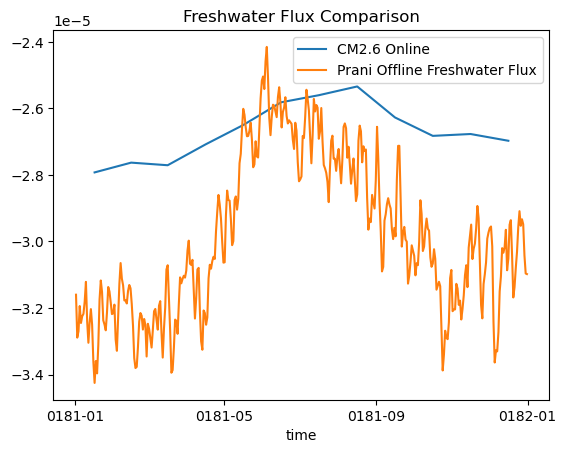

In [103]:
fig, ax = plt.subplots()

FF_CM26.plot(label=f"CM2.6 Online", ax=ax)

FF_spatialAvg.plot(label='Prani Offline Freshwater Flux', ax=ax)

ax.set_title("Freshwater Flux Comparison")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="best")
